# Graph exploration

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import pygsp as gsp

Data_path = 'Data/'
Net_path = 'networks/'

Functions

In [11]:
def graph_summary(G, diameter=False, display=True, return_GC=False):
    """
    Display properties of the given nx.Graph
    ------
    INPUT 
        |---- G : nx.Graph
    OUTPUT 
        |---- G_props : dictionary of properties
    """
    # get the giant component:
    G_large = G.subgraph(max(nx.connected_components(G), key=len))#max(nx.connected_component_subgraphs(G), key=len)
    
    G_props = {}
    G_props['N edges'] = G.number_of_edges()
    G_props['N nodes'] = G.number_of_nodes()
    G_props['N connected comp.'] = nx.number_connected_components(G)
    G_props['Giant comp. size'] = G_large.number_of_nodes()
    G_props['avg degree'] = 2*G_props['N edges'] /G_props['N nodes']
    G_props['density'] = nx.density(G)
    if diameter : 
        G_props['diameter'] = nx.diameter(G_large) 
    else : 
        G_props['diameter'] = None
    G_props['avg clustering coeff.'] = nx.average_clustering(G)
    
    if display:
        print('>>> Network Summary:')
        for prop_name, prop_value in G_props.items():
            print(f'\t |---- {prop_name} : {prop_value}')
    
    if return_GC: return G_props
            
def graph_plots(G):
    matplotlib.rcParams['text.usetex'] = True
    fig, axs = plt.subplots(3,1,figsize=(8,24))
    ax1, ax2, ax3 = axs[0], axs[1], axs[2]
    
    ax1.set_title('Graph Adjacency Matrix')
    ax1.spy(nx.adjacency_matrix(G).toarray())
    
    degrees = dict(G.degree()).values()
    k = np.linspace(np.min(list(degrees)), np.max(list(degrees)), np.ptp(list(degrees))+1)

    hist = ax2.hist(degrees, color='goldenrod', bins=np.max(list(degrees)), linewidth=0.1, edgecolor='black')
    ax2.set_title('Degree distribution', loc='left', fontsize=16)
    ax2.set_xlabel('k', fontsize=12)
    ax2.set_ylabel('number of nodes', fontsize=12)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlim([0.5,np.max(list(degrees))+10])
    ax2.set_ylim(bottom=1e-3)

    # fit power law
    a, m, s = stats.powerlaw.fit(list(degrees)) # get estimates of distribution parameters
    pdf_g = stats.powerlaw.pdf(k, a, scale=s)
    ax2.plot(k, pdf_g * len(list(degrees)), label=r"Powerlaw : $p(k) = {0:.3f} \cdot k^{{{0:.3f}-1}}$".format(a), \
                linewidth=2, color='dimgray')

    # fit exponential 
    m, s = stats.expon.fit(list(degrees)) # get estimates of distribution parameters
    pdf_g = stats.expon.pdf(k, scale=s)
    ax2.plot(k, pdf_g * len(list(degrees)), label=r"Exponential : $p(k) = \frac{{1}}{{{0:.3f}}}  \cdot e^{{- \frac{{k}}{{{{{0:.3f}}}}}}}$".format(s), \
                linewidth=2, color='black', linestyle='-')
    
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='upper right', fontsize=14)
    
    # A spectrum
    eigenvalues = nx.linalg.spectrum.normalized_laplacian_spectrum(G)
    ax3.plot(eigenvalues, color='goldenrod', linewidth=3)
    ax3.set_title('Adjacency Spectrum', loc='left', fontsize=16)
    ax3.set_xlabel('Eigenvalues Index', fontsize=12)
    ax3.set_ylabel('eigenvalues', fontsize=12)
    
    plt.show()
    matplotlib.rcParams['text.usetex'] = False
    
def get_quadratic_form(L, f):
    """
    get the Laplacian (L) Quatratic form of a signal (f). 
    INPUT
        |---- L [numpy array] the Laplacian of a graph of dimension N_node x N_node
        |---- f [numpy array] the signal on the graph of dimension N_node x 1
    OUTPUT 
        |---- qf [float] the value of f^T x L x f
    """
    return float(f.transpose() @ L @ f)

def signal_GFT(G, s, ax=None, **kwargs):
    """
    compute and plot the GFT of the passed signal s.
    INPUT
        |---- G [pygsp graph] 
        |---- s [numpy array] the signal on the graph of dimension N_node x 1
        |---- ax [matplotlib.Axes] the ax on which to plot the GFT
    OUTPUT 
        |---- s_hat [numpy array] the signal in the fourier domain
    """
    # compute the fourier basis (only performed if not already computed)
    G.compute_fourier_basis()
    
    # get GFT of signal
    s_hat = G.gft(s)
    # plot in ax
    if not ax is None:
        ax.plot(G.e, np.abs(s_hat),**kwargs)
    
    return s_hat

Load the network

In [9]:
G = nx.read_gexf(Net_path+'network_all025.gexf')
A = nx.adjacency_matrix(G).toarray()

## Explore the Graph Structure

In [12]:
graph_summary(G)

>>> Network Summary:
	 |---- N edges : 109874
	 |---- N nodes : 4802
	 |---- N connected comp. : 100
	 |---- Giant comp. size : 4690
	 |---- avg degree : 45.76176593086214
	 |---- density : 0.009531715461541792
	 |---- diameter : None
	 |---- avg clustering coeff. : 0.6240759564321612


//anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5680: RuntimeWarning: divide by zero encountered in power
  return a*x**(a-1.0)


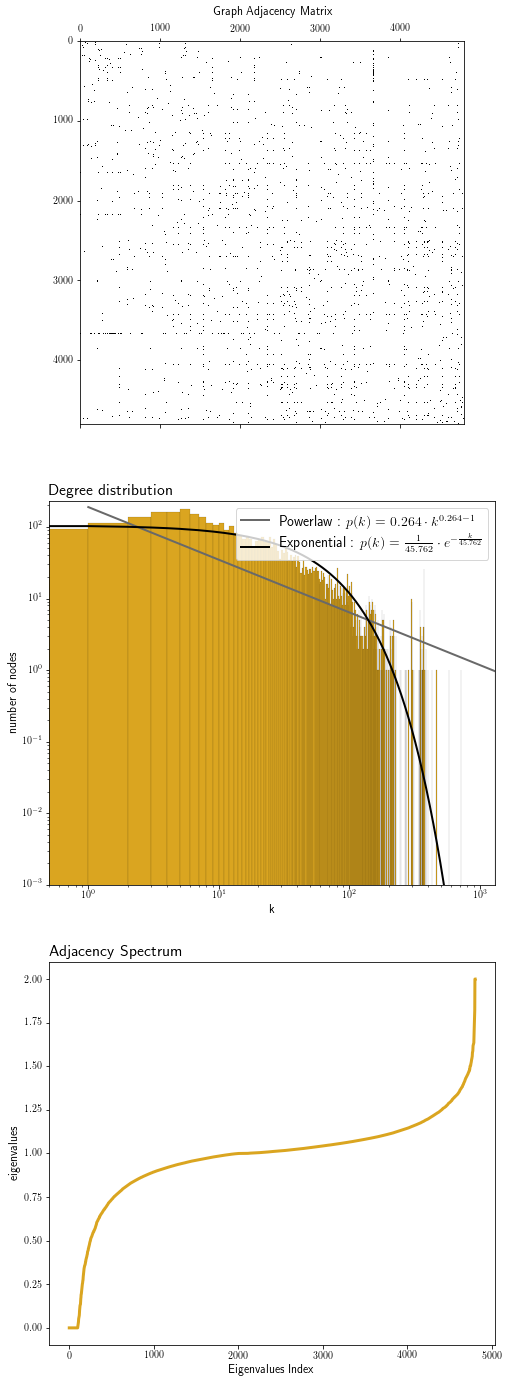

In [13]:
graph_plots(G)

## Explore the nodes attributes

Get the normalized laplacian matrix. The smoothness of a signal $f$ on the graph is assessed by $f^TLf$. If the value is low the signal is rather smooth. Then the GTF spectrum of some signals are explored

In [14]:
# make a pygsp graph from the networkx one
G_sp = gsp.graphs.Graph(nx.adjacency_matrix(G), lap_type='normalized')

//anaconda3/lib/python3.7/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


2020-01-04 14:51:05,375:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4802 x 4802) may take some time.


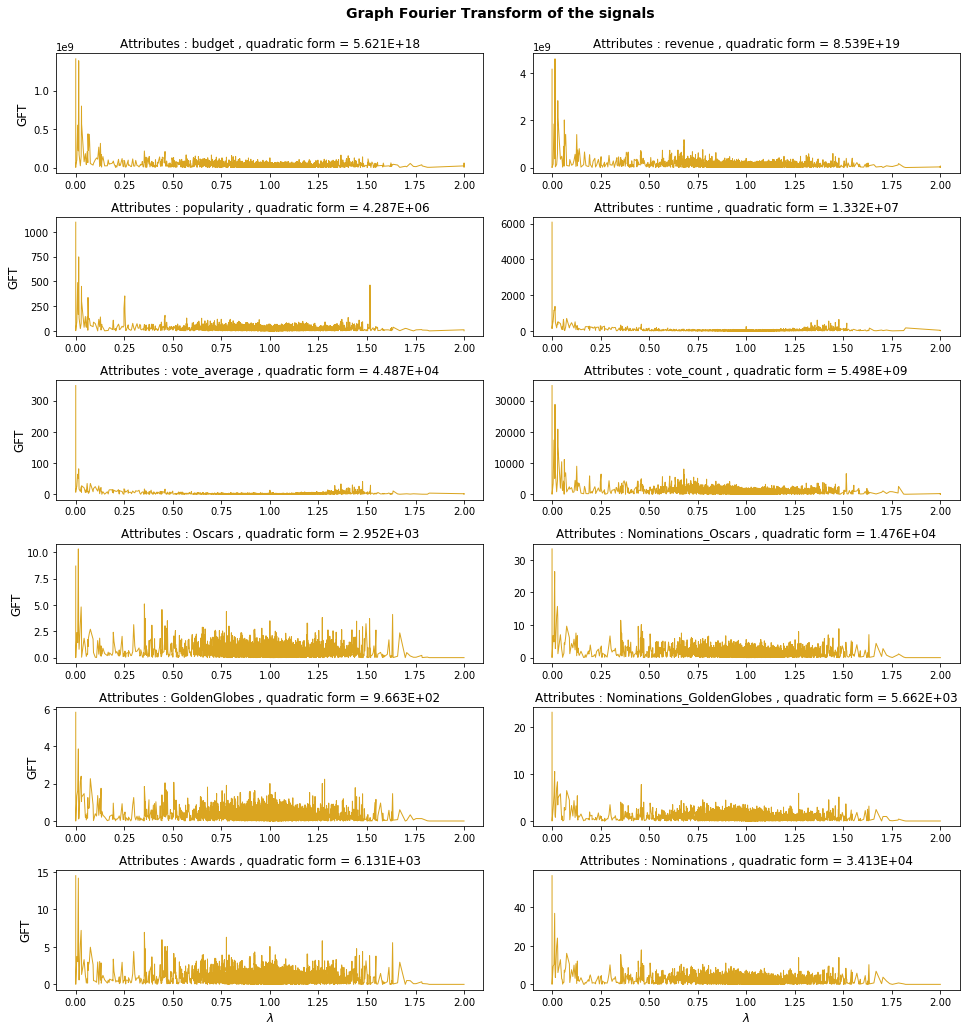

In [15]:
matplotlib.rcParams['text.usetex'] = False
attributes = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count', \
                     'Oscars', 'Nominations_Oscars', 'GoldenGlobes', 'Nominations_GoldenGlobes', \
                     'Awards', 'Nominations']

fig, axs = plt.subplots(6,2, figsize=(14,14))
fig.suptitle('Graph Fourier Transform of the signals', x=0.5, y=1.02, fontsize=14, fontweight='bold')
for atr, ax in zip(attributes, axs.reshape(-1)):
    signal = np.array([list(nx.get_node_attributes(G, atr).values())]).transpose()
    quad_form = get_quadratic_form(G_sp.L, signal)
    _ = signal_GFT(G_sp, signal, ax=ax, linewidth=1, color='Goldenrod')
    ax.set_title(r'Attributes : {0} , quadratic form = {1:.3E}'.format(atr, quad_form))

for ax in axs[-1,:]: ax.set_xlabel('$\lambda$', fontsize=12)
for ax in axs[:,0] : ax.set_ylabel('GFT', fontsize=12)
    
fig.tight_layout()
plt.show()

GFT and quadradtic form of a constant signal of ones

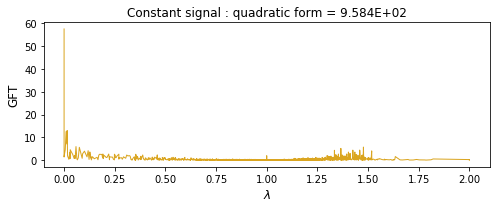

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
signal = np.ones((G.number_of_nodes(),1))
quad_form = get_quadratic_form(G_sp.L, signal)
_ = signal_GFT(G_sp, signal, ax=ax, linewidth=1, color='Goldenrod')
ax.set_title(r'Constant signal : quadratic form = {0:.3E}'.format(quad_form))
ax.set_xlabel('$\lambda$', fontsize=12)
ax.set_ylabel('GFT', fontsize=12)
fig.tight_layout()
plt.show()

## Overview Figure 

In [83]:
G_props = graph_summary(G, display=False, return_GC=True)
G_large = G.subgraph(max(nx.connected_component(G), key=len))
G_props_large = graph_summary(G_large, diameter=True, display=False, return_GC=True)

In [84]:
def G_props_to_table(G_props):
    labels = []
    data = []
    for name, val in G_props.items():
        labels.append(name)
        if val is not None: 
            data.append(str(round(val,4)))
        else:
            data.append(str(val))
            
    return np.array(data), np.array(labels)

In [90]:
def plot_degree(G, ax, title_fs=12):
    degrees = dict(G.degree()).values()
    k = np.linspace(np.min(list(degrees)), np.max(list(degrees)), np.ptp(list(degrees))+1)

    hist = ax.hist(degrees, color='goldenrod', bins=np.max(list(degrees)), linewidth=0, edgecolor='black')
    ax.set_title('Degree distribution', loc='left', fontsize=title_fs)
    ax.set_xlabel('k', fontsize=12)
    ax.set_ylabel('number of nodes', fontsize=12)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim([0.5,np.max(list(degrees))+10])
    ax.set_ylim([1e-3, 1e4])

    # fit power law
    a, m, s = stats.powerlaw.fit(list(degrees)) # get estimates of distribution parameters
    pdf_g = stats.powerlaw.pdf(k, a, scale=s)
    ax.plot(k, pdf_g * len(list(degrees)), label=r"Powerlaw : $p(k) = {0:.3f} \cdot k^{{{0:.3f}-1}}$".format(a), \
                linewidth=2, color='dimgray')

    # fit exponential 
    m, s = stats.expon.fit(list(degrees)) # get estimates of distribution parameters
    pdf_g = stats.expon.pdf(k, scale=s)
    ax.plot(k, pdf_g * len(list(degrees)), label=r"Exponential : $p(k) = \frac{{1}}{{{0:.3f}}}  \cdot e^{{- \frac{{k}}{{{{{0:.3f}}}}}}}$".format(s), \
                linewidth=2, color='black', linestyle='-')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize=12)

In [86]:
# get table data
data_whole, labels = G_props_to_table(G_props)
data_large, _ = G_props_to_table(G_props_large)
data = np.stack([data_whole, data_large], axis=1)

In [87]:
G_sp = gsp.graphs.Graph(nx.adjacency_matrix(G), lap_type='normalized')

//anaconda3/lib/python3.7/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [88]:
# features correlation
features_df = pd.read_csv(Data_path+'features.csv', usecols=[2,3,4,5,6,7])
labels_df = pd.read_csv(Data_path+'labels.csv', usecols=[6,7])
df = pd.concat([features_df, labels_df], axis=1)
corr_df = df.corr(method = 'spearman').loc[:,['Awards','Nominations']]
corr_df = corr_df.drop(['Awards','Nominations'])

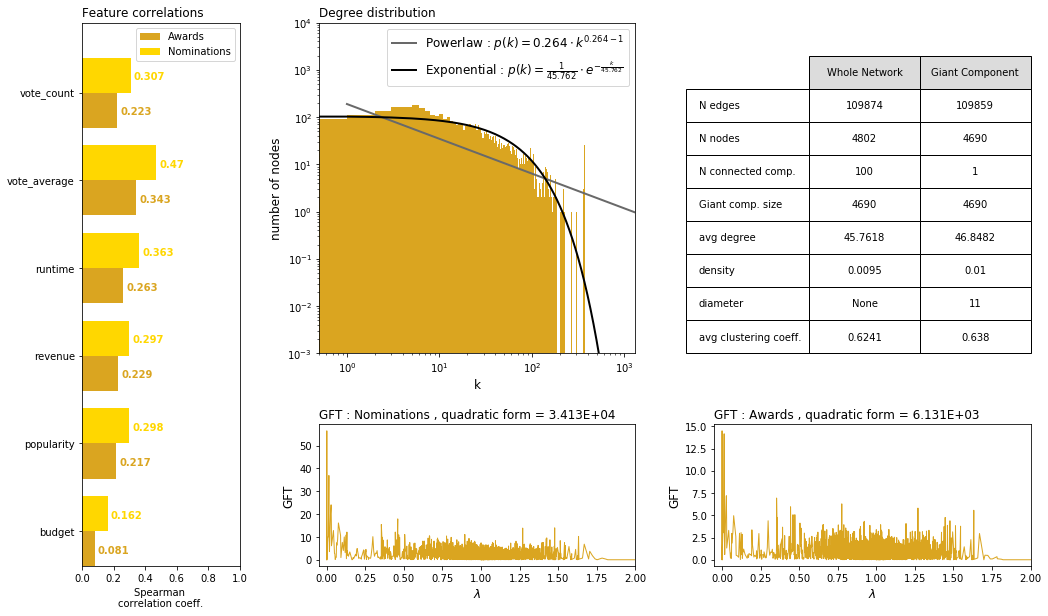

In [104]:
fig = plt.figure(figsize=(17, 10))
gs = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3, width_ratios=[0.2 ,0.4, 0.4], height_ratios=[0.7, 0.3])
title_fs = 12

# Degree dist
ax_deg = fig.add_subplot(gs[0,1])
plot_degree(G, ax_deg, title_fs)

# Table
ax_table = fig.add_subplot(gs[0,2])
ax_table.set_axis_off()
table = ax_table.table(cellText=data, rowLabels=labels, cellLoc='center', \
                                     colColours=['gainsboro'] * len(labels), colLabels=['Whole Network', 'Giant Component'], loc='center', \
                                     bbox=[0.3, 0, 0.7, 0.9])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1,1)

# GFT 
ax_gft1 = fig.add_subplot(gs[1,1])
ax_gft2 = fig.add_subplot(gs[1,2])

for atr, ax in zip(['Nominations', 'Awards'], [ax_gft1, ax_gft2]):
    signal = np.array([list(nx.get_node_attributes(G, atr).values())]).transpose()
    quad_form = get_quadratic_form(G_sp.L, signal)
    _ = signal_GFT(G_sp, signal, ax=ax, linewidth=1, color='Goldenrod')
    ax.set_title(r'GFT : {0} , quadratic form = {1:.3E}'.format(atr, quad_form), loc='left', fontsize=title_fs)
    ax.set_xlabel('$\lambda$', fontsize=12)
    ax.set_ylabel('GFT', fontsize=12)
    ax.set_xlim([-0.05,2])
    
# Correlations
ax_corr = fig.add_subplot(gs[:,0])
ind = np.arange(len(corr_df))
width = 0.4
ax_corr.barh(ind, corr_df.Awards, width, color='Goldenrod', label='Awards')
ax_corr.barh(ind + width, corr_df.Nominations, width, color='Gold', label='Nominations')
ax_corr.set(yticks=ind + 0.5*width, yticklabels=corr_df.index, ylim=[2*width - 1, len(corr_df)])
ax_corr.set_title('Feature correlations', fontsize=title_fs, loc='left')
ax_corr.set_xlabel('Spearman \ncorrelation coeff.')
ax_corr.set_xlim([0,1])
#ax_corr.grid(True, which='major', axis='x')
ax_corr.set_axisbelow(True)
ax_corr.legend()

for i, v in enumerate(corr_df.Awards):
    ax_corr.text(v + 0.02, i - 0.05, str(round(v,3)), color='Goldenrod', fontweight='bold')
for i, v in enumerate(corr_df.Nominations):
    ax_corr.text(v + 0.02, i + 0.35, str(round(v,3)), color='Gold', fontweight='bold')

fig.savefig('Figures/exploration_overview.svg')
plt.show()